In [1]:
!rm -r AI2022BS
!git clone https://github.com/UmbertoJr/AI2022BS.git

rm: cannot remove 'AI2022BS': No such file or directory
Cloning into 'AI2022BS'...
remote: Enumerating objects: 192, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 192 (delta 103), reused 126 (delta 44), pack-reused 0
Receiving objects: 100% (192/192), 2.11 MiB | 18.02 MiB/s, done.
Resolving deltas: 100% (103/103), done.


### Simulated Annealing


In [2]:
import numpy as np

from AI2022BS.src.utils import compute_length


def sa(solution, instance, constant_temperature=0.95, iterations_for_each_temp=100):
    # initial setup
    temperature = instance.best_sol / np.sqrt(instance.nPoints)
    current_sol = np.array(solution)
    current_len = compute_length(solution, instance.dist_matrix)
    best_sol = np.array(solution)
    best_len = current_len

    # main loop
    while temperature > 0.001:
        # TODO
        for it in range(iterations_for_each_temp):
            next_sol, delta_E = random_sol_from_neigh(current_sol, instance)
            if delta_E < 0:
                current_sol = next_sol
                current_len += delta_E
                if current_len < best_len:
                    best_sol = current_sol
                    best_len = current_len
            else:
                r = np.random.uniform(0, 1)
                if r < np.exp(- delta_E / temperature):
                    current_sol = next_sol
                    current_len += delta_E

        temperature *= constant_temperature
    # END TODO
    return best_sol.tolist()


def random_sol_from_neigh(solution, instance):
    i, j = np.random.choice(np.arange(1, len(solution) - 1), 2, replace=False)
    i, j = np.sort([i, j])
    solution = np.roll(solution, np.random.randint(len(solution)))
    return sa_swap2opt(solution, i, j), gain(i, j, solution, instance.dist_matrix)


def sa_swap2opt(tsp_sequence, i, j):
    new_tsp_sequence = np.copy(tsp_sequence)
    new_tsp_sequence[i:j + 1] = np.flip(tsp_sequence[i:j + 1], axis=0)  # flip or swap ?
    return new_tsp_sequence


def gain(i, j, tsp_sequence, matrix_dist):
    old_link_len = (matrix_dist[tsp_sequence[i], tsp_sequence[i - 1]] + matrix_dist[
        tsp_sequence[j], tsp_sequence[j + 1]])
    changed_links_len = (matrix_dist[tsp_sequence[j], tsp_sequence[i - 1]] + matrix_dist[
        tsp_sequence[i], tsp_sequence[j + 1]])
    return - old_link_len + changed_links_len


###  solving with ['nn'] ####


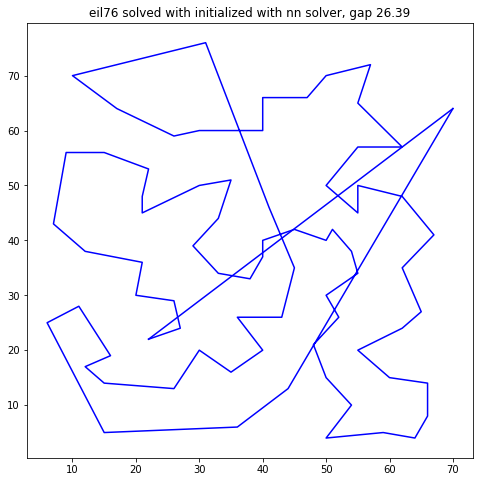

best solution with len 680.0 
with a total time of 0.00808 seconds
solution found has a 26.39 % gap
3.7652182579040527


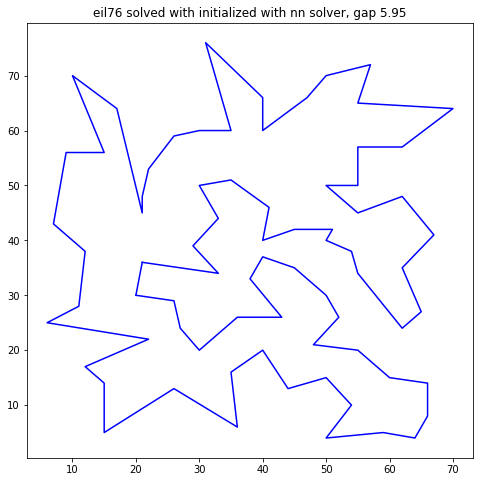

 5.95 % gap


In [3]:
from AI2022BS.src.TSP_solver import TSPSolver
from time import time as t
from AI2022BS.src.io_tsp import ProblemInstance
from AI2022BS.src.constructive_algorithms import (
    random_method,
    nearest_neighbor,
    best_nearest_neighbor,
    multi_fragment_mf
)

available_solvers = {
    "random": random_method,
    "nn":nearest_neighbor,
    "best_nn":best_nearest_neighbor,
    "multi_fragment": multi_fragment_mf
}

example_problem = "AI2022BS/problems/eil76.tsp"
p_inst = ProblemInstance(example_problem)

solver = TSPSolver("nn", p_inst, available_solvers)
start = t()
solver.compute_solution(return_value=False, verbose=True)
end = t()

solver.plot_solution()
print(f"best solution with len {solver.found_length} \nwith a total time of {np.round(end - start, 5)} seconds")
print(f"solution found has a {solver.gap} % gap")

start = t()
solution = sa(solver.solution, p_inst)
end = t()
print(end -  start)
solver.method = "nn folowed by SA"

assert solver.pass_and_check_if_solution_is_valid(solution), "Solution non valid"
solver.solved = True
solver.solution = solution
solver.plot_solution()
solver._gap()
print(f" {solver.gap} % gap")


## Iterated Local Search

In [4]:
class DoubleBridge:
  
  @staticmethod
  def difference_cost(solution, a, b, c, d, matrix):
    n = matrix.shape[0]
    to_remove = matrix[solution[a-1], solution[a]] + matrix[solution[b-1], solution[b]] + matrix[solution[c-1], solution[c]] + matrix[solution[d-1], solution[d]]
    to_add = matrix[solution[a], solution[c-1]] + matrix[solution[b], solution[d-1]] + matrix[solution[c], solution[a-1]] + matrix[solution[d], solution[b-1]]
    return to_add - to_remove


  @staticmethod
  def perturbate_solution(solution, actual_cost, matrix):
    a, b, c, d = np.sort(np.random.choice(matrix.shape[0], size=4, replace=False))
    B = solution[a:b]
    C = solution[b:c]
    D = solution[c:d]
    A = np.concatenate((solution[d:], solution[:a]))
    new_solution = np.concatenate((A,D,C,B))
    new_length = actual_cost + DoubleBridge.difference_cost(solution, a, b, c, d, matrix)
    return new_solution, new_length

In [5]:

def ils(solution, instance, constant_temperature=0.95, iterations_for_each_temp=100):
    # initial setup
    temperature = instance.best_sol / np.sqrt(instance.nPoints)
    current_sol = np.array(solution)
    current_len = compute_length(solution, instance.dist_matrix)
    best_sol = np.array(solution)
    best_len = current_len

    # main loop
    while temperature > 0.001:
        for it in range(iterations_for_each_temp):
            next_sol_p, new_cost_p = DoubleBridge.perturbate_solution(current_sol,
                                                                      current_len,
                                                                      instance.dist_matrix)
            # print(new_cost_p)
            next_sol, new_cost = local_search(next_sol_p, new_cost_p, instance)
            # print(new_cost, current_len)
            # print()
            # break
            if new_cost - current_len < 0:
                # print('updated sol')
                current_sol = next_sol
                current_len = new_cost
                if current_len < best_len:
                    # print("update best")
                    best_sol = current_sol
                    best_len = current_len
                    # print(best_len)
                # print()
            else:
                r = np.random.uniform(0, 1)
                if r < np.exp(- (new_cost - current_len) / temperature):
                    current_sol = next_sol
                    current_len = new_cost

        temperature *= constant_temperature
    return best_sol


def local_search(solution, new_len, instance):
    matrix_dist = instance.dist_matrix
    new_tsp_sequence = np.copy(np.array(solution))
    uncross = 0
    seq_length = len(solution)
    try_again = True
    while uncross < 10:
      new_tsp_sequence = np.roll(new_tsp_sequence, np.random.randint(seq_length)).astype(np.int)
      new_tsp_sequence, new_reward, uncr_ = step2opt(new_tsp_sequence, matrix_dist, new_len)
      uncross += uncr_
      if new_reward < new_len:
        new_len = new_reward
        try_again = True
      else:
        if try_again:
          try_again = False
        else:
          return new_tsp_sequence, new_len
    
    return new_tsp_sequence.tolist(), new_len
    
def step2opt(solution, matrix_dist, distance):
  seq_length = len(solution)
  tsp_sequence = np.copy(solution)
  uncrosses = 0
  for i in range(seq_length):
    for j in range(i + 1, seq_length):
      if gain_2opt(i, j, tsp_sequence, matrix_dist) > 0:
        new_distance = distance - gain_2opt(i, j, tsp_sequence, matrix_dist)
        tsp_sequence = swap2opt(tsp_sequence, i, j)
        # print(new_distance, distance)
        return tsp_sequence, new_distance, 1
  return tsp_sequence, distance, 1


def swap2opt(tsp_sequence, i, j):
    new_tsp_sequence = np.copy(tsp_sequence)
    new_tsp_sequence[i:j] = np.flip(tsp_sequence[i:j], axis=0)  
    return new_tsp_sequence.astype(np.int)


def gain_2opt(i, j, tsp_sequence, matrix_dist):
    try:
      old_link_len = (matrix_dist[tsp_sequence[i], 
                                  tsp_sequence[i - 1]] 
                      + matrix_dist[tsp_sequence[j],
                                    tsp_sequence[j - 1]])
      changed_links_len = (matrix_dist[tsp_sequence[j], 
                                       tsp_sequence[i]] 
                           + matrix_dist[tsp_sequence[i - 1],
                                         tsp_sequence[j - 1]])
      return + old_link_len - changed_links_len
    except:
      print(i, j , tsp_sequence[i], tsp_sequence[j], tsp_sequence[i - 1], tsp_sequence[j - 1])
    

###  solving with ['nn'] ####


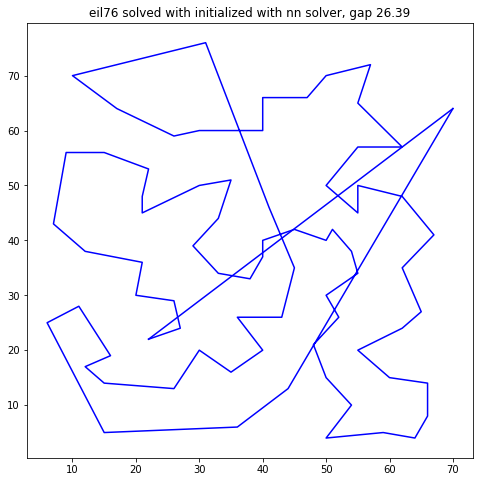

best solution with len 680.0 
with a total time of 0.00398 seconds
solution found has a 26.39 % gap


<ipython-input-5-82d0ee0ea239>:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  new_tsp_sequence = np.roll(new_tsp_sequence, np.random.randint(seq_length)).astype(np.int)
<ipython-input-5-82d0ee0ea239>:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for

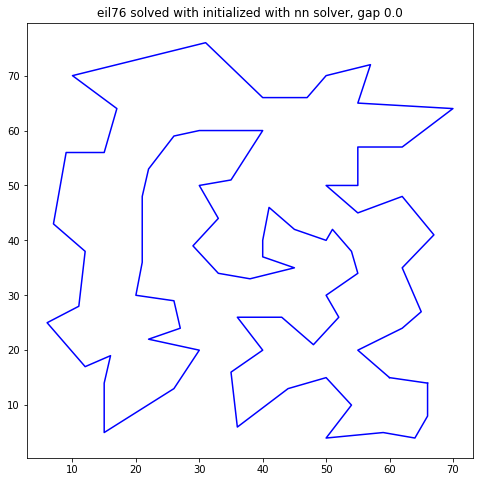

best solution with len 538.0 
with a total time of 251.81838 seconds
solution found has a 0.0 % gap


In [6]:
solver = TSPSolver("nn", p_inst, available_solvers)
start = t()
solver.compute_solution(return_value=False, verbose=True)
end = t()

solver.plot_solution()
print(f"best solution with len {solver.found_length} \nwith a total time of {np.round(end - start, 5)} seconds")
print(f"solution found has a {solver.gap} % gap")

start = t()
solution = ils(solver.solution, p_inst)
end = t()
solver.method = "nn folowed by ILS"

assert solver.pass_and_check_if_solution_is_valid(solution), "Solution non valid"
solver.solved = True
solver.solution = solution
solver.plot_solution()
solver._gap()
print(f"best solution with len {solver.found_length} \nwith a total time of {np.round(end - start, 5)} seconds")
print(f"solution found has a {solver.gap} % gap")